In [1]:
#Mount Google drive
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#change current working directory
#%cd "/content/drive/Shareddrives/NLI/2_slot_filling"

In [3]:
!pip install transformers
!pip install accelerate
!pip install seqeval
#!pip install datasets
!python3 -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=19a6fc7e3ea16934c776f6d0cdc1e003fc5472231ea1c93c2a7da35340534614
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertForTokenClassification, BertTokenizerFast, BertConfig
from transformers import RobertaForTokenClassification, RobertaTokenizerFast, RobertaConfig
from transformers import XLNetForTokenClassification, XLNetTokenizerFast, XLNetConfig
from transformers import XLMForTokenClassification, XLMRobertaTokenizerFast, XLMConfig
from transformers import DistilBertForTokenClassification, DistilBertTokenizerFast, DistilBertConfig
from transformers import AlbertForTokenClassification, AlbertTokenizerFast, AlbertConfig
from transformers import AdamW
from transformers import EarlyStoppingCallback, IntervalStrategy
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, Dataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import recall_score, precision_score, f1_score
from torch import cuda
from sklearn.metrics import confusion_matrix
from seqeval.metrics import  classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import normalize
from itertools import product
import json
import shutil

import matplotlib.pyplot as plt
import seaborn as sns

#import nltk

#nltk.download('punkt')

import spacy

nlp = spacy.load("en_core_web_lg")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
SAVE_MODEL_TO_PATH = "./saved_models/"
#TRAIN_DATA_SAVE_PATH = "utterances_tags/train.json"
#TEST_DATA_SAVE_PATH = "utterances_tags/test.json"
#VALID_DATA_SAVE_PATH = "utterances_tags/valid.json"

TRAIN_DATA_SAVE_PATH = "/kaggle/input/slot-filling-words-tags/train.json"
TEST_DATA_SAVE_PATH = "/kaggle/input/slot-filling-words-tags/test.json"
VALID_DATA_SAVE_PATH = "/kaggle/input/slot-filling-words-tags/valid.json"

#ckpt_path = SAVE_MODEL_TO_PATH + 'checkpoint.pt'
#best_model_path = SAVE_MODEL_TO_PATH + 'best_model.pt'

best_model_path = '/kaggle/input/saved-models/2_model_slot_filling.pt'

PRETRAINED_MODELS = {
    'bert': 'bert-large-uncased',
    'roberta': 'roberta-base',
    'xlnet': 'xlnet-large-cased',
    'xlm': 'xlm-mlm-en-2048',
    'distilbert': 'distilbert-base-uncased',
    'albert':'albert-base-v2'
}

MODEL_CLASSES = {
    'bert' : (BertForTokenClassification, BertTokenizerFast, BertConfig),
    'roberta' : (RobertaForTokenClassification, RobertaTokenizerFast, RobertaConfig),
    'xlnet' : (XLNetForTokenClassification, XLNetTokenizerFast, XLNetConfig),
    'xlm' : (XLMForTokenClassification, XLMRobertaTokenizerFast, XLMConfig),
    'distilbert' : (DistilBertForTokenClassification, DistilBertTokenizerFast, DistilBertConfig),
    'albert' : (AlbertForTokenClassification, AlbertTokenizerFast, AlbertConfig)
}

MODEL_TYPE = 'roberta'
PRETRAINED_MODEL_NAME = PRETRAINED_MODELS[MODEL_TYPE]

model_class, tokenizer_class, config_class = MODEL_CLASSES[MODEL_TYPE]

LEARNING_RATE = 1e-5
BATCH_SIZE = 64
EPOCHS = 50
WEIGHT_DECAY = 0.01

## Loading preprocessed data

In [6]:
def save_variable_to_json(variable, file_path):
    with open(file_path, 'w') as file:
        json.dump(variable, file)

def load_variable_from_json(file_path):
    with open(file_path, 'r') as file:
        variable = json.load(file)
    return variable

In [7]:
try:
    X_train, y_train = load_variable_from_json(TRAIN_DATA_SAVE_PATH)
    X_test, y_test = load_variable_from_json(TEST_DATA_SAVE_PATH)
    X_valid, y_valid = load_variable_from_json(VALID_DATA_SAVE_PATH)

    print('Data loaded from file.')
except:
    print('No saved data found.')

Data loaded from file.


In [8]:
longest_train_data = max(X_train + X_test + X_valid, key=lambda x: len(x))
print('Longest utterance length:', len(longest_train_data))

num_labels = len(set([act for act_list in y_train for act in act_list ]))
print('Number of labels:', num_labels)

all_labels = sorted(set([act for act_list in y_train for act in act_list ]))
print('Labels:', all_labels)

tag2index = {tag: i for i, tag in enumerate(all_labels)}
index2tag = {i: tag for tag, i in tag2index.items()}

print("tag2index:", tag2index)
print("index2tag:", index2tag)


Longest utterance length: 60
Number of labels: 30
Labels: ['B-hotel-area', 'B-hotel-bookday', 'B-hotel-bookpeople', 'B-hotel-bookstay', 'B-hotel-name', 'B-hotel-pricerange', 'B-hotel-stars', 'B-hotel-type', 'B-restaurant-area', 'B-restaurant-bookday', 'B-restaurant-bookpeople', 'B-restaurant-booktime', 'B-restaurant-food', 'B-restaurant-name', 'B-restaurant-pricerange', 'I-hotel-area', 'I-hotel-bookday', 'I-hotel-bookpeople', 'I-hotel-bookstay', 'I-hotel-name', 'I-hotel-pricerange', 'I-hotel-type', 'I-restaurant-area', 'I-restaurant-bookday', 'I-restaurant-bookpeople', 'I-restaurant-booktime', 'I-restaurant-food', 'I-restaurant-name', 'I-restaurant-pricerange', 'O']
tag2index: {'B-hotel-area': 0, 'B-hotel-bookday': 1, 'B-hotel-bookpeople': 2, 'B-hotel-bookstay': 3, 'B-hotel-name': 4, 'B-hotel-pricerange': 5, 'B-hotel-stars': 6, 'B-hotel-type': 7, 'B-restaurant-area': 8, 'B-restaurant-bookday': 9, 'B-restaurant-bookpeople': 10, 'B-restaurant-booktime': 11, 'B-restaurant-food': 12, 'B-re

## Tokenizing and creating dataloader

In [9]:
# Load the pre-trained BERT model and tokenizer
tokenizer = tokenizer_class.from_pretrained(PRETRAINED_MODEL_NAME, add_prefix_space=True)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [10]:
longest_tokenized_train_data = []
for word in longest_train_data:
    tokenized_word = tokenizer.tokenize(word)
    longest_tokenized_train_data.extend(tokenized_word)

print('Longest tokenized utterance length:', len(longest_tokenized_train_data))
print('Longest tokenized utterance:', longest_tokenized_train_data)

max_length = min(2 ** (len(longest_tokenized_train_data)-1).bit_length(), 512)
print('Max chosen length:', max_length)



Longest tokenized utterance length: 78
Longest tokenized utterance: ['ĠHotel', '-', 'In', 'form', 'Ġ|', 'ĠHotel', '-', 'In', 'form', 'Ġ,', 'ĠHotel', '-', 'Request', 'Ġ|', 'ĠHotel', '-', 'In', 'form', 'Ġ,', 'ĠHotel', '-', 'Request', 'Ġ,', 'ĠRestaurant', '-', 'In', 'form', 'Ġ|', 'ĠI', 'Ġwant', 'Ġch', 'inese', 'Ġfood', 'Ġin', 'Ġcheap', 'Ġprice', 'Ġrange', 'Ġin', 'Ġwest', 'Ġside', 'Ġof', 'Ġtown', 'Ġ.', 'Ġa', 'Ġ3', 'Ġstar', 'Ġhotel', 'Ġthat', 'Ġbe', 'Ġexpensive', 'Ġwest', 'Ġside', 'Ġof', 'Ġtown', 'Ġ.', 'Ġa', 'Ġ3', 'Ġstar', 'Ġhotel', 'Ġthat', 'Ġbe', 'Ġexpensive', 'Ġand', 'Ġinclude', 'Ġwifi', 'Ġ.', 'Ġalso', 'Ġthe', 'Ġhotel', 'Ġaddress', 'Ġ,', 'Ġarea', 'Ġ,', 'Ġand', 'Ġpost', 'code', 'Ġplease', 'Ġ.']
Max chosen length: 128


In [11]:
class CustomDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_length):
        self.X = X
        self.labels = y
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):

        # step 1: get the sentence and word labels        
        sentence = self.X[index]
        word_labels = self.labels[index]

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True,
                             padding='max_length',
                             truncation=True,
                             max_length=self.max_length)

        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2index[label] for label in word_labels]

        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100

        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)

        return item

In [12]:
# Smaller dataset to try
p = 1
n_train_samples = int(len(X_train) * p)
n_test_samples = int(len(X_test) * p)
n_valid_samples = int(len(X_valid) * p)

print("Train samples: ", n_train_samples)
print("Test samples: ", n_test_samples)
print("Valid samples: ", n_valid_samples)

Train samples:  23542
Test samples:  2619
Valid samples:  2668


In [13]:
train_dataset = CustomDataset(X_train[:n_train_samples], y_train[:n_train_samples], tokenizer, max_length)
test_dataset = CustomDataset(X_test[:n_test_samples], y_test[:n_test_samples], tokenizer, max_length)
valid_dataset = CustomDataset(X_valid[:n_valid_samples], y_valid[:n_valid_samples], tokenizer, max_length)

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


## Defining model and training

In [16]:
def load_ckp(checkpoint_fpath, model):
    checkpoint = torch.load(checkpoint_fpath, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    index2tag = checkpoint['mlb']
    return model, index2tag

def save_ckp(state,  best_model_path):
    torch.save(state, best_model_path)


In [17]:
model = model_class.from_pretrained(PRETRAINED_MODEL_NAME,  num_labels=num_labels)
model = model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, correct_bias=False)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
def valid(model, data_loader):
    model.eval()
    
    val_targets = []
    val_outputs = []
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader):

            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
            loss = outputs[0]
            eval_logits = outputs[1]

            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)

            # if idx % 100==0:
            #     loss_step = eval_loss/nb_eval_steps
            #     print(f"Validation loss per 100 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)

            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(labels)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [index2tag[id.item()] for id in eval_labels]
    predictions = [index2tag[id.item()] for id in eval_preds]

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps

    return labels, predictions, eval_loss, eval_accuracy

In [20]:
def train(model, training_loader, optimizer):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    for batch in tqdm(training_loader):

        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
        loss, tr_logits = outputs[0], outputs[1]
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)

        # if idx % 100==0:
        #     loss_step = tr_loss/nb_tr_steps
        #     print(f"Training loss per 100 training steps: {loss_step:.2f}")

        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))

        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=10
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps

    return epoch_loss, tr_accuracy

In [21]:
def train_model(num_epochs, train_dataloader, valid_dataloader, model, optimizer, best_model_path, patience = 1):
    valid_loss_min = np.Inf
    
    num_not_improved = 0
    for epoch in range(1, num_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0

        print("#################### Epoch {}: Training Start    ####################".format(epoch))

        train_loss, train_accuracy = train( model, train_dataloader, optimizer)

        print("#################### Epoch {}: Training End      ####################".format(epoch))

        print()
        print("#################### Epoch {}: Validation Start ####################".format(epoch))

        valid_labels, valid_predictions, valid_loss, valid_accuracy = valid(model, valid_dataloader)

        print("#################### Epoch {}: Validation End   ####################".format(epoch))
        print()
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(epoch, train_loss, train_accuracy))
        print('Epoch: {} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch, valid_loss, valid_accuracy))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))

            checkpoint = {
                        'state_dict': model.state_dict(),
                        'mlb' : index2tag
                    }

            save_ckp(checkpoint, best_model_path)
            valid_loss_min = valid_loss
            num_not_improved = 0
        else:
            num_not_improved += 1
            if num_not_improved >= patience:
                print('Not improvement for more than:', num_not_improved)
                break
        print()
    print("#################### Training finished     ####################")
    return model


In [22]:
try:
  trained_model, index2tag = load_ckp(best_model_path, model)
except:
  print('Need to be trained first.')
  trained_model = train_model(EPOCHS, train_dataloader, valid_dataloader, model, optimizer, best_model_path)


## Evaluation on test set

In [23]:
test_labels, test_predictions, test_loss, test_accuracy  = valid(trained_model, test_dataloader)

100%|██████████| 41/41 [00:13<00:00,  3.00it/s]


In [24]:
all_test_labels = sorted(set(test_labels))

print('Accuracy:', accuracy_score([test_labels], [test_predictions]))
print('Precision:', precision_score([test_labels], [test_predictions], average='weighted'))
print('Recall:', recall_score([test_labels], [test_predictions], average='weighted'))
print('F1:', f1_score([test_labels], [test_predictions], average='weighted'))

report = classification_report([test_labels], [test_predictions])
print(report)

Accuracy: 0.991493705341953
Precision: 0.9100077601437038
Recall: 0.9663684048133292
F1: 0.936880434722072
                       precision    recall  f1-score   support

           hotel-area       0.85      0.93      0.89       176
        hotel-bookday       0.92      1.00      0.96       207
     hotel-bookpeople       0.89      0.98      0.93       203
       hotel-bookstay       0.97      0.97      0.97       259
           hotel-name       0.90      0.97      0.93       137
     hotel-pricerange       0.90      0.96      0.93       217
          hotel-stars       0.96      0.98      0.97       190
           hotel-type       0.74      0.88      0.81       243
      restaurant-area       0.95      0.97      0.96       273
   restaurant-bookday       0.92      0.99      0.96       160
restaurant-bookpeople       0.94      1.00      0.97       177
  restaurant-booktime       0.96      0.99      0.97       210
      restaurant-food       0.95      0.97      0.96       379
      rest

In [25]:
def remove_bio_tags(tags):
    return sorted(set(tag[2:] if tag.startswith('B-') or tag.startswith('I-') else tag for tag in tags))

## Confusion matrix

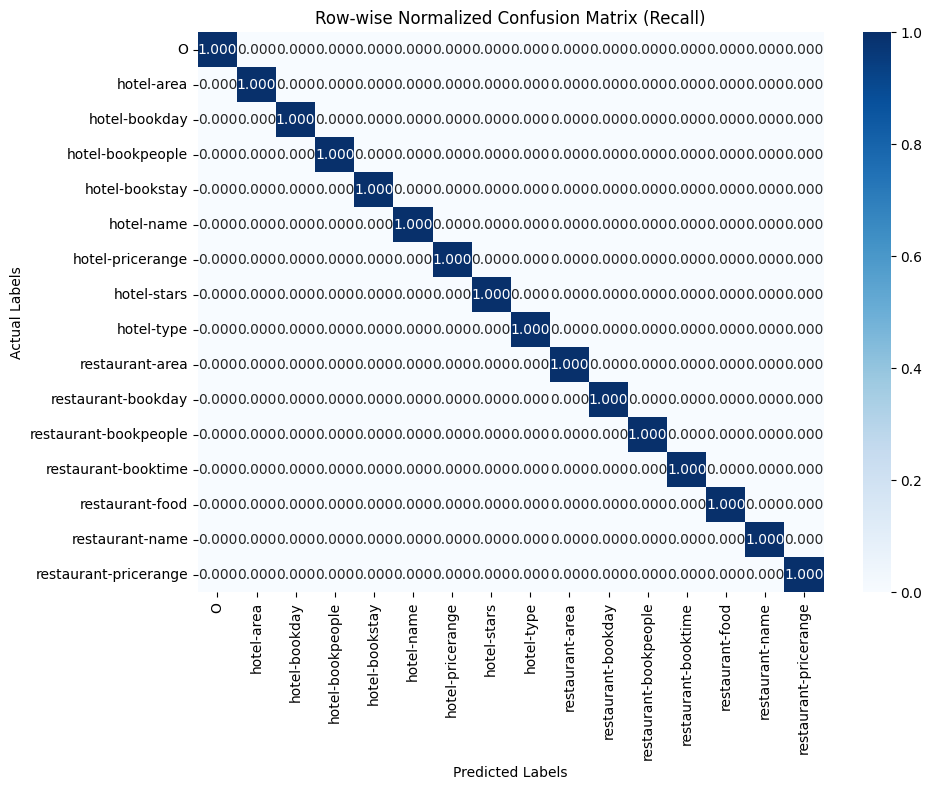

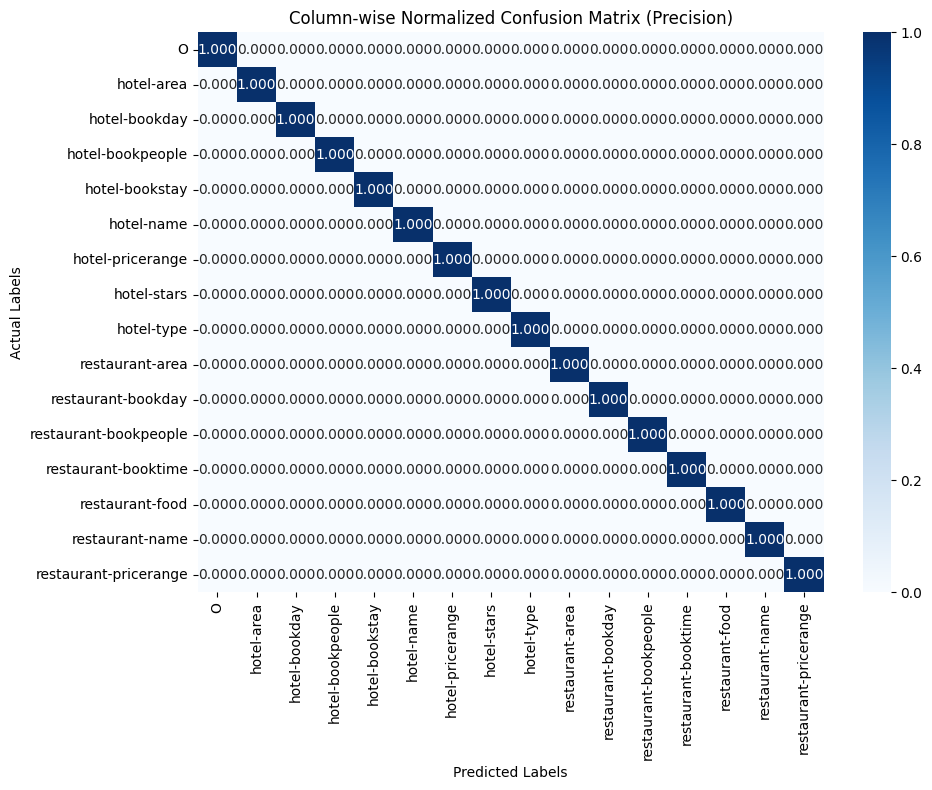

In [26]:
no_bio_tag_test_labels = remove_bio_tags(test_labels)
no_bio_tag_test_predictions = remove_bio_tags(test_predictions)
no_bio_tag_all_test_labels = remove_bio_tags(all_test_labels)

# Compute the confusion matrix
confusion = confusion_matrix(no_bio_tag_test_labels, no_bio_tag_test_predictions)

# Normalize by row sums (recall)
confusion_row_norm = normalize(confusion, norm='l1', axis=1)

# Normalize by column sums (precision)
confusion_col_norm = normalize(confusion, norm='l1', axis=0)

# Plotting the row-wise normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_row_norm, annot=True, cmap="Blues", fmt=".3f", xticklabels=no_bio_tag_all_test_labels, yticklabels=no_bio_tag_all_test_labels)
plt.title('Row-wise Normalized Confusion Matrix (Recall)')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.tight_layout()
plt.savefig('confusion_recall_mlp.png')
plt.show()

# Plotting the column-wise normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_col_norm, annot=True, cmap="Blues", fmt=".3f", xticklabels=no_bio_tag_all_test_labels, yticklabels=no_bio_tag_all_test_labels)
plt.title('Column-wise Normalized Confusion Matrix (Precision)')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.tight_layout()
plt.savefig('confusion_precision_mlp.png')
plt.show()

## Predict function

In [27]:
def parse(sentence):
    # Tokenize
    sentence = nlp(sentence)
    # Remove stop words
    sentence = " ".join([token.lemma_ for token in sentence])
    
    return sentence

In [28]:
def predict(model, tokenizer, sentence):
    model.eval()
    device = 'cuda' if cuda.is_available() else 'cpu'
    words = parse(sentence).split()
    inputs = tokenizer(words,
                    is_split_into_words=True,
                    return_offsets_mapping=True,
                    padding='max_length',
                    truncation=True,
                    max_length=max_length,
                    return_tensors="pt")
    # move to gpu
    ids = inputs["input_ids"].to(device)
    mask = inputs["attention_mask"].to(device)
    # forward pass
    outputs = model(ids, attention_mask=mask)
    logits = outputs[0]

    active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
    flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

    tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
    token_predictions = [index2tag[i] for i in flattened_predictions.cpu().numpy()]
    wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

    prediction = []
    for token_pred, mapping in zip(wp_preds, inputs["offset_mapping"].squeeze().tolist()):
    #only predictions on first word pieces are important
        if mapping[0] == 0 and mapping[1] != 0:
            prediction.append(token_pred[1])
    return words, prediction